# USD vs. GBP

### Part I : Peeling out the monetary shock

In [1]:
Docker = "To peel out a monetary shocks TS, the data needed are:\n \
          * The federal funds rate series \n \
          * The inflation sequence \n \
          * The output gap sequence."
"""To get the output gap sequence, we use a quadratic function to fit the trend and determine the gap."""
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
sns.set()

def flashBack(old,n,mode="month"):
    #Get the back the argued period of time
    if mode == "month":
        #Flash back by month
        year = old.year - int((n - n%12)/12)
        res = n%12
        if res >= old.month:
            #We have to go back an extra year
            year = year - 1
            month = 12 + old.month - res
        else:
            month = old.month - res
        result = datetime(year,month,old.day)
    return result

def grabForward(target,domain):
    #Get the closest datetime to the target dt, in the domain time series indexed by the datetimess.
    tmp = domain[target:]
    try:
        return tmp.iloc[0,:].values
    except:
        return tmp.iloc[0]

def grabNearest(target,domain,output=False):
    #Get the colest datetime to the target dt.
    #Domain has to a datetime indexed Series or DataFrame.
    left = domain[:target]
    right = domain[target:]
    if len(left) == 0:
        tt = right.index[0]
    elif len(right) == 0:
        tt = left.index[-1]
    else:
        candidate = [right.index[0],left.index[-1]]
        dev = [abs(x-target) for x in candidate]
        if dev[0] <= dev[1]:
            tt = candidate[0]
        else:
            tt = candidate[1]
    if output == True:
        print("@Function [grabNearest] grabbed tt at %s"%tt)
    if isinstance(domain,pd.Series):
        return domain[tt]
    elif isinstance(domain,pd.DataFrame):
        return domain[tt].values
    else:
        raise ValueError

In [2]:
#Configuration
start = datetime(1994,1,1)
end = datetime(2008,1,1)
regressStart = datetime(1990,1,1)
regressEnd = datetime(2008,1,1)
latex = False
pin_date = 15      #The standing date for month frequecy data entry.

#### Get the output gap time series

In [3]:
#Data inquiry
otpt_raw = pd.read_excel("data/production.xlsx")
otpt = pd.Series(otpt_raw.iloc[:,1].values,index=otpt_raw.iloc[:,0].values,name="industrial_output")[start:end]

In [4]:
#Fitting the quadratic model
regress = pd.DataFrame({'output':otpt})
regress['time'] = np.arange(len(regress))
regress['timesq'] = regress['time']**2
regress['constant'] = 1
model = sm.OLS(regress['output'],regress.drop('output',axis=1))
gapResult = model.fit(cov_type="HC3")
#Get the residual series
output_gap = gapResult.resid
output_gap.index = pd.to_datetime(output_gap.index)
output_gap.name = "outputgap"

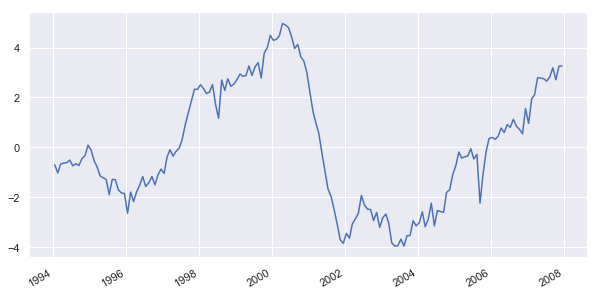

In [5]:
output_gap.plot(figsize=(10,5),grid=True)

In [6]:
#Set the common time line
timeline = output_gap.index

#### Get the inflation time series

In [7]:
#Data inquiry
infl_raw = pd.read_excel("data/inflation.xlsx",skiprows=3)
cpi = pd.Series(infl_raw.iloc[:,1].values,index=infl_raw.iloc[:,0].values,name="cpi")[flashBack(start,1):end]
infl = cpi.pct_change().dropna()

#### Get the federal funds rate

In [8]:
#Data inquiry
iff_raw = pd.read_excel("data/FEDFUNDS.xls",skiprows=10)
iff_tmp = pd.Series(iff_raw['FEDFUNDS'].values,index=iff_raw['observation_date'].values,name = "iff")

In [9]:
#Shaping the series, awkward.
iff1 = pd.Series(np.nan,index=timeline)
for time in timeline:
    iff1[time] = grabForward(target=time,domain=iff_tmp)
head = flashBack(timeline[0],1)
iff1[head] = grabForward(head,iff_tmp)
iff1 = iff1.sort_index()
iff = iff1[iff1.index[1:]]
iff_lag = iff1.shift().dropna()
iff.name = "iffrate"
iff_lag.name = "iffratelag"

#### Run the Taylor's model.

In [10]:
regress = pd.DataFrame([iff,output_gap,infl,iff_lag]).T
regress['Constant'] = 1
taylorModel = sm.OLS(regress.iffrate,regress.drop('iffrate',axis=1))
taylorResult = taylorModel.fit(cov_type="HC3")

In [11]:
estimation = regress.drop("iffrate",axis=1).values.dot(taylorResult.params.values)

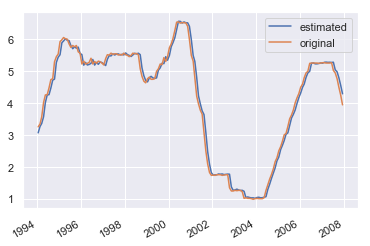

In [12]:
compare = pd.DataFrame({"estimated":estimation,"original":iff},index=timeline)
compare.plot()

#### Peel out the monetary shock of US

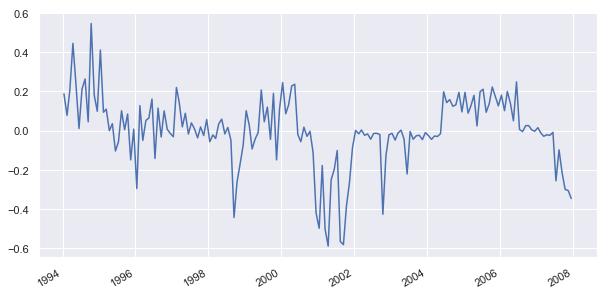

In [13]:
monetaryShock = taylorResult.resid
monetaryShock.name = "monetaryShock"
monetaryShock.plot(figsize=(10,5),grid=True)

### Part II : Get the UIP deviation estimation

In [14]:
"""The way to estimate the deviation from UIP equation is to use a forward difference of spot exchange rate"""

'The way to estimate the deviation from UIP equation is to use a forward difference of spot exchange rate'

In [15]:
#Data inquiry
exch_raw = pd.read_excel("data/exchange_rate.xlsx")
exch = np.log(pd.Series(1/exch_raw["JAPANESE YEN TO US $ (WMR) - EXCHANGE RATE"].values,index=exch_raw['Name'].values,name="CADollarPrice"))
interest_raw = pd.read_excel("data/interest_rate.xlsx")
iUS = pd.Series(interest_raw["TR US GVT BMK BID YLD 1Y (U$) - RED. YIELD"].values,index=interest_raw.iloc[:,0].values,name="iUS")
iJP = pd.Series(interest_raw["JAPANESE YEN 1Y DEPOSIT (FT/TR) - MIDDLE RATE"].values,index=interest_raw.iloc[:,0].values,name="iCA")

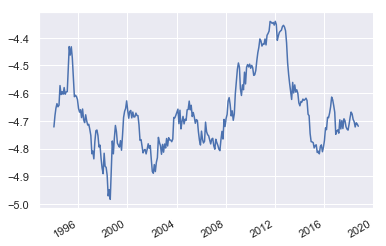

In [16]:
exch.dropna().plot()

In [17]:
#Shaping the LHS,RHS,p_t series
pt = pd.Series(np.nan,index=timeline)
sdif = pd.Series(np.nan,index=timeline)
idif = pd.Series(np.nan,index=timeline)

for time in timeline:
    print(time)
    sdif[time] = grabNearest(target=datetime(time.year+1,time.month,time.day),domain=exch) - grabNearest(time,exch)
    idif[time] = grabNearest(time,iUS,True) - grabNearest(time,iJP,True)

pt = sdif-idif

1994-01-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-01-14 00:00:00
@Function [grabNearest] grabbed tt at 1994-01-14 00:00:00
1994-02-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-02-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-02-15 00:00:00
1994-03-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-03-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-03-15 00:00:00
1994-04-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-04-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-04-15 00:00:00
1994-05-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-05-16 00:00:00
@Function [grabNearest] grabbed tt at 1994-05-16 00:00:00
1994-06-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-06-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-06-15 00:00:00
1994-07-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-07-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-07-15 00:00:00
1994-08-15 00:00:00
@Function [grabNearest] grab

@Function [grabNearest] grabbed tt at 2004-10-15 00:00:00
@Function [grabNearest] grabbed tt at 2004-10-15 00:00:00
2004-11-15 00:00:00
@Function [grabNearest] grabbed tt at 2004-11-15 00:00:00
@Function [grabNearest] grabbed tt at 2004-11-15 00:00:00
2004-12-15 00:00:00
@Function [grabNearest] grabbed tt at 2004-12-15 00:00:00
@Function [grabNearest] grabbed tt at 2004-12-15 00:00:00
2005-01-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-01-14 00:00:00
@Function [grabNearest] grabbed tt at 2005-01-14 00:00:00
2005-02-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-02-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-02-15 00:00:00
2005-03-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-03-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-03-15 00:00:00
2005-04-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-04-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-04-15 00:00:00
2005-05-15 00:00:00
@Function [grabNearest] grabbed tt at 2005-05-16

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.644
Date:                Wed, 05 Dec 2018   Prob (F-statistic):              0.202
Time:                        17:30:10   Log-Likelihood:                -299.33
No. Observations:                 168   AIC:                             602.7
Df Residuals:                     166   BIC:                             608.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         -3.7448      0.156    -24.077

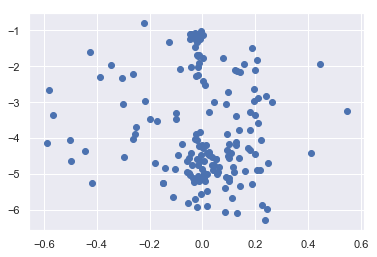

In [18]:
#Regress pt on monetaryShock
if not (pt.index == monetaryShock.index).all(): #Check the index
    raise ValueError
dataset = pd.DataFrame({"UIPdev":pt,"Constant":1,"monetaryShock":monetaryShock}).dropna()
model1 = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock"]])
result1 = model1.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in result1.summary().tables:
        print(line.as_latex_tabular())
print(result1.summary())
plt.scatter(monetaryShock.values,pt.values)

In [19]:
#Adding a exchange rate lag term
exch_lag = exch - exch.shift(3)
intervn = pd.Series([grabNearest(x,exch_lag) for x in timeline],index=timeline,name="intervention")
dataset["intervention"] = intervn
dataset = dataset.dropna()
model2 = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock","intervention"]])
result2 = model2.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in result2.summary().tables:
        print(line.as_latex_tabular())
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.973
Date:                Wed, 05 Dec 2018   Prob (F-statistic):             0.0207
Time:                        17:30:10   Log-Likelihood:                -288.43
No. Observations:                 165   AIC:                             582.9
Df Residuals:                     162   BIC:                             592.2
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         -3.7815      0.152    -24.958

In [20]:
modelInterv = sm.OLS(dataset["UIPdev"],dataset[["Constant","intervention"]])
resultInterv = modelInterv.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in resultInterv.summary().tables:
        print(line.as_latex_tabular())
print(resultInterv.summary())

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.961
Date:                Wed, 05 Dec 2018   Prob (F-statistic):             0.0273
Time:                        17:30:10   Log-Likelihood:                -289.89
No. Observations:                 165   AIC:                             583.8
Df Residuals:                     163   BIC:                             590.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Constant        -3.7785      0.153    -24.669   

In [21]:
dataset["exchgrt"] = pd.Series([grabNearest(x,exch) for x in dataset.index],index=dataset.index,name="exchgrt")
dataset.to_stata("dataset.dta")

# Control the terms in UIP regression.

In [22]:
dataset["sdif"] = sdif
dataset["idif"] = idif

In [23]:
#Dataset1 is a lagged shock and intervention version of original dataset
dataset1 = dataset.copy()

lag_shock,lag_intervention = 6,1
dataset1["monetaryShock"] = dataset1["monetaryShock"].shift(lag_shock)
dataset1["intervention"] = dataset1["intervention"].shift(lag_intervention)
dataset1 = dataset1.dropna()
model3 = sm.OLS(dataset1["sdif"],dataset1[["Constant","monetaryShock","intervention","idif"]])
result3 = model3.fit(cov_type="HAC",cov_kwds={"maxlags":1})
"""
for lag1 in range(1,10):
    for lag2 in range(1,10):
        dataset1 = dataset.copy()
        dataset1["monetaryShock"] = dataset1["monetaryShock"].shift(lag1)
        dataset1["intervention"] = dataset1["intervention"].shift(lag2)
        dataset1 = dataset1.dropna()
        model3 = sm.OLS(dataset1["sdif"],dataset1[["Constant","monetaryShock","intervention","idif"]])
        result3 = model3.fit(cov_type="HAC",cov_kwds={"maxlags":1})
        print("[lag1:%s,lag2:%s] coef of RHS is %s" %(lag1,lag2,result3.pvalues["monetaryShock"]))
result3.bse
"""
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   sdif   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     14.98
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           1.30e-08
Time:                        17:30:10   Log-Likelihood:                 151.61
No. Observations:                 159   AIC:                            -295.2
Df Residuals:                     155   BIC:                            -283.0
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          0.0793      0.019      4.128

In [24]:
if latex == True:
    for line in result3.summary().tables:
        print(line.as_latex_tabular())

In [25]:
UIPmodel = sm.OLS(dataset["sdif"],dataset[["Constant","idif"]])
UIPresult = UIPmodel.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in UIPresult.summary().tables:
        print(line.as_latex_tabular())
UIPresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   sdif   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     29.11
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           2.37e-07
Time:                        17:30:10   Log-Likelihood:                 147.43
No. Observations:                 165   AIC:                            -290.9
Df Residuals:                     163   BIC:                            -284.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.1118      0.020      5.636      0.000       0.073       0.151
idif          -0.0303      0.006     -5.396      0.000      -0.041      -0.019
==============================================================================
Omnibus:                        2.382   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                2.440
Skew:                           0.267   Prob(JB):                        0.295
Kurtosis:                       2.738   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [26]:
model4 = sm.OLS(dataset1["UIPdev"],dataset1[["Constant","monetaryShock","intervention"]])
result4 = model4.fit(cov_type="HAC",cov_kwds={"maxlags":1})
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 UIPdev   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     16.16
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           4.18e-07
Time:                        17:30:10   Log-Likelihood:                -269.19
No. Observations:                 159   AIC:                             544.4
Df Residuals:                     156   BIC:                             553.6
Df Model:                           2                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         -3.7909      0.146    -25.947      0.000      -4.077      -3.505
monetaryShock    -3.0544      0.551     -5.546      0.000      -4.134      -1.975
intervention      5.1912      2.026      2.562      0.010       1.220       9.163
==============================================================================
Omnibus:                        8.995   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.099
Skew:                           0.415   Prob(JB):                       0.0287
Kurtosis:                       2.381   Cond. No.                         17.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [27]:
model5 = sm.OLS(dataset1["UIPdev"],dataset1[["Constant","monetaryShock","intervention"]])
result5 = model5.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in result5.summary().tables:
        print(line.as_latex_tabular())
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     16.16
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           4.18e-07
Time:                        17:30:10   Log-Likelihood:                -269.19
No. Observations:                 159   AIC:                             544.4
Df Residuals:                     156   BIC:                             553.6
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         -3.7909      0.146    -25.947

In [28]:
dataset1.to_stata("dataset1.dta")

In [29]:
"""
dataset["monetaryShock_lag1"] = dataset["monetaryShock"].shift()
dataset["monetaryShock_lag2"] = dataset["monetaryShock_lag1"].shift()
dataset["monetaryShock_lag3"] = dataset["monetaryShock_lag2"].shift()
dataset["monetaryShock_lag4"] = dataset["monetaryShock_lag3"].shift()
dataset["monetaryShock_lag5"] = dataset["monetaryShock_lag4"].shift()

dataset = dataset.dropna()
dynamicModel = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock","monetaryShock_lag1","monetaryShock_lag2",
                                                "monetaryShock_lag3","monetaryShock_lag4","monetaryShock_lag5"]])
dynamicResult = dynamicModel.fit(cov_type="HAC",cov_kwds={"maxlags":1})
dynamicResult.summary()
"""

'\ndataset["monetaryShock_lag1"] = dataset["monetaryShock"].shift()\ndataset["monetaryShock_lag2"] = dataset["monetaryShock_lag1"].shift()\ndataset["monetaryShock_lag3"] = dataset["monetaryShock_lag2"].shift()\ndataset["monetaryShock_lag4"] = dataset["monetaryShock_lag3"].shift()\ndataset["monetaryShock_lag5"] = dataset["monetaryShock_lag4"].shift()\n\ndataset = dataset.dropna()\ndynamicModel = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock","monetaryShock_lag1","monetaryShock_lag2",\n                                                "monetaryShock_lag3","monetaryShock_lag4","monetaryShock_lag5"]])\ndynamicResult = dynamicModel.fit(cov_type="HAC",cov_kwds={"maxlags":1})\ndynamicResult.summary()\n'

In [30]:
#plt.plot(np.arange(6),dynamicResult.params.iloc[1:].values)
#plt.grid(True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Dec, 2018
Time:                     17:30:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.46818
Nobs:                     159.000    HQIC:                  -6.76622
Log likelihood:           128.893    FPE:                0.000940331
AIC:                     -6.97001    Det(Omega_mle):     0.000803559
--------------------------------------------------------------------
Results for equation UIPdev
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.102137         0.056349           -1.813           0.070
L1.UIPdev                0.747843         0.087604            8.537           0.000
L1.monetaryShock        -0.847416         0.156

c:\users\49048\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


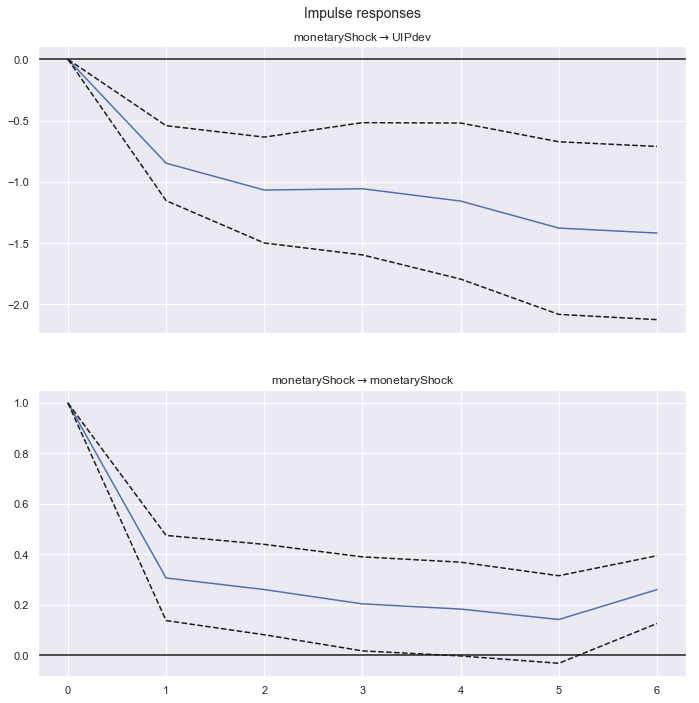

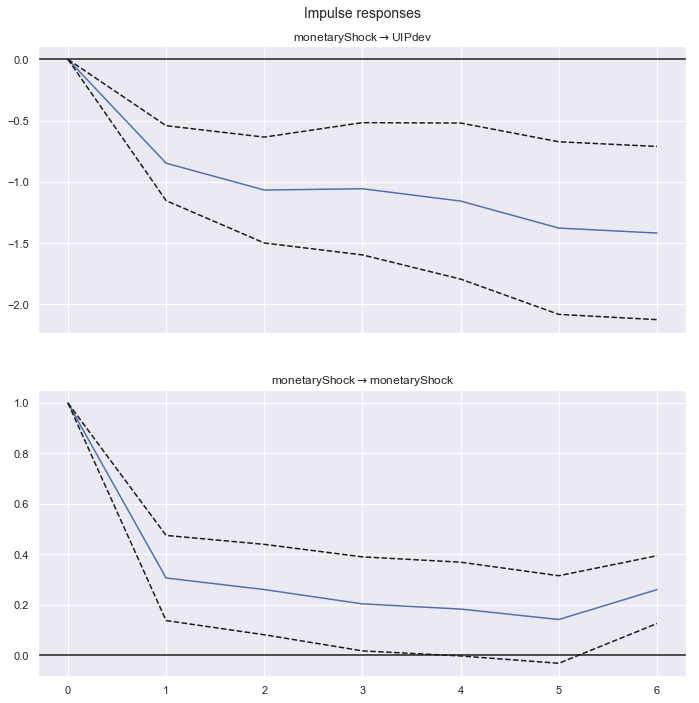

In [31]:
import statsmodels.tsa.api as ts
Vardata = dataset.copy()
Vardata["monetaryShock"] = Vardata["monetaryShock"]
Vardata = Vardata.dropna()
Varmodel = ts.VAR(Vardata[["UIPdev","monetaryShock"]])
Varresult = Varmodel.fit(6)
print(Varresult.summary())
irf = Varresult.irf(6)
irf.plot(impulse="monetaryShock")

In [32]:
#Adding controll for The other country's inflation and unemployment.
infUK = pd.Series(infl_raw["JP CPI: NATIONAL MEASURE SADJ"].pct_change().values,index=infl_raw.iloc[:,0].values)
dataset["inflationJP"]= infUK[start:end]
unemp_raw = pd.read_excel("data/unemployment_rate.xlsx")
UKunemp = pd.Series(unemp_raw["JP UNEMPLOYMENT RATE (METHO BREAK OCT 2010) SADJ"].values,index=unemp_raw.iloc[:,0].values)
dataset["unempJP"] = UKunemp
dataset["inflationUS"]  = infl

In [33]:
DCmodel = sm.OLS(dataset.dropna()["UIPdev"],dataset.dropna()[["Constant","monetaryShock","inflationJP","unempJP","inflationUS"]])
DCresult = DCmodel.fit(cov_type="HAC",cov_kwds={"maxlags":1})
DCresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 UIPdev   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     6.457
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           7.66e-05
Time:                        17:30:11   Log-Likelihood:                -269.67
No. Observations:                 165   AIC:                             549.3
Df Residuals:                     160   BIC:                             564.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         -7.8141      0.803     -9.731      0.000      -9.388      -6.240
monetaryShock     0.2458      0.733      0.335      0.737      -1.190       1.682
inflationJP      24.5817     38.448      0.639      0.523     -50.774      99.938
unempJP           0.9529      0.195      4.893      0.000       0.571       1.335
inflationUS      -4.3112     40.992     -0.105      0.916     -84.655      76.033
==============================================================================
Omnibus:                        0.203   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.325
Skew:                          -0.071   Prob(JB):                        0.850
Kurtosis:                       2.836   Cond. No.                     2.12e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\users\49048\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


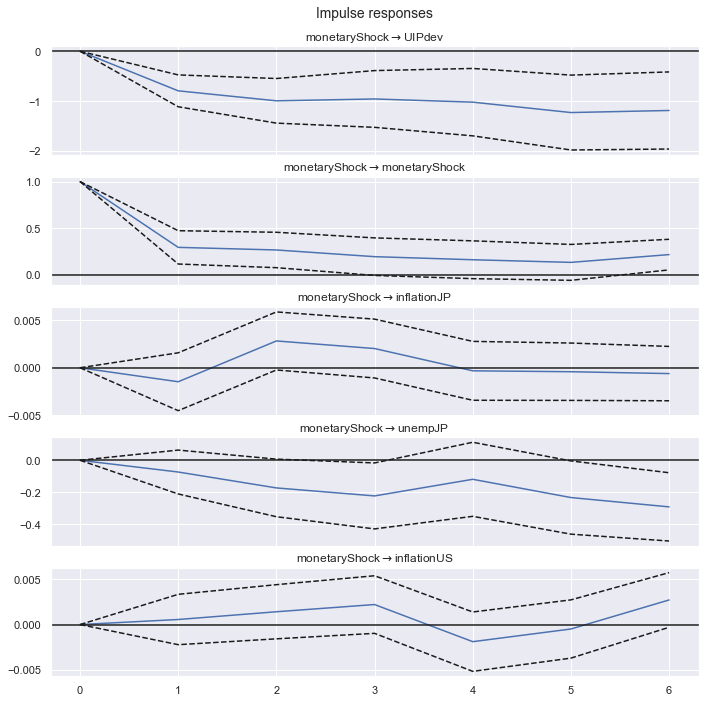

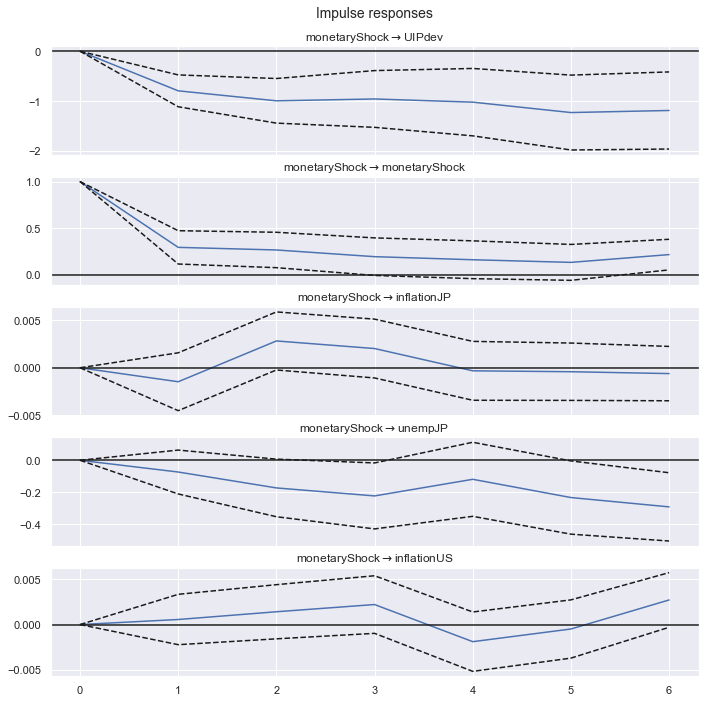

In [34]:
VarCmodel = ts.VAR(dataset.dropna()[["UIPdev","monetaryShock","inflationJP","unempJP","inflationUS"]])
VarCresult = VarCmodel.fit(6)
VarCresult.irf(6).plot(impulse="monetaryShock")